In [1]:
import sys

sys.path.insert(0, '../../../PSC')

# Turn video data into data in Stiefel manifold

In [2]:
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import os

files = ['shahar_run.avi',  'lyova_wave2.avi']

print(files)

w = 8 # sliding window, number of frames
s = 4 # stride
k = 4
ys = []
labels = []

for f in files:
  print(f)
  frames = iio.imread(f, index=None)

  # manually convert the video
  gray_frames = np.dot(frames, [0.2989, 0.5870, 0.1140])
  gray_frames = np.round(gray_frames).astype(np.uint8)
  gray_frames = gray_frames - np.mean(gray_frames, axis=0)
  print(gray_frames.shape)

  n_frames = len(gray_frames)
  # reshape to (number of frames) by (number of pixels)
  gray_frames = gray_frames.reshape((n_frames, -1))

  label = f.split('.')[0].split('_')[-1] # 'moshe_jump.avi' -> 'jump'
  #label = f.split('.')[0].split('_')[0] # 'moshe_jump.avi' -> 'moshe'

  for idx in range(0, len(gray_frames)-w, s):
    w_frames = gray_frames[idx:idx+w].T
    u, _, _ = np.linalg.svd(w_frames, full_matrices=False)
    ys.append(u[:, :k])
    labels.append(label)

# now everything is in Stiefel shape
ys = np.array(ys)
print(ys.shape)

labels = np.array(labels)

N = ys.shape[1]


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
labels = le.fit_transform(labels)
print(le.classes_)

from collections import Counter
print(Counter(labels))

['shahar_run.avi', 'lyova_wave2.avi']
shahar_run.avi
(67, 144, 180)
lyova_wave2.avi
(57, 144, 180)
(28, 25920, 4)
['run' 'wave2']
Counter({0: 15, 1: 13})


In [3]:
np.savez('video.npz', ys=ys, labels=labels)

## Visualize the singualr vectors (or columns of data points in Stiefel manifold)

run


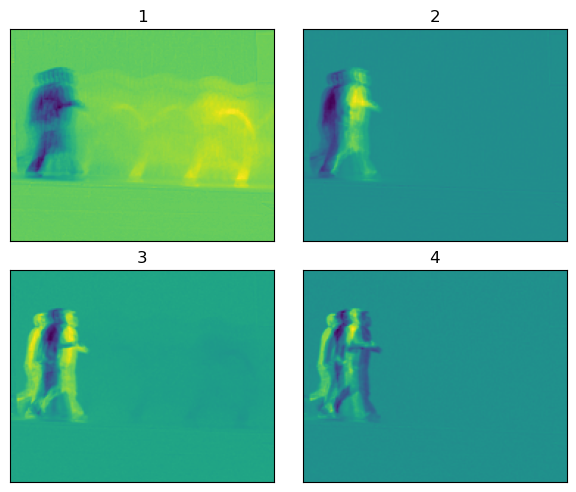

wave2


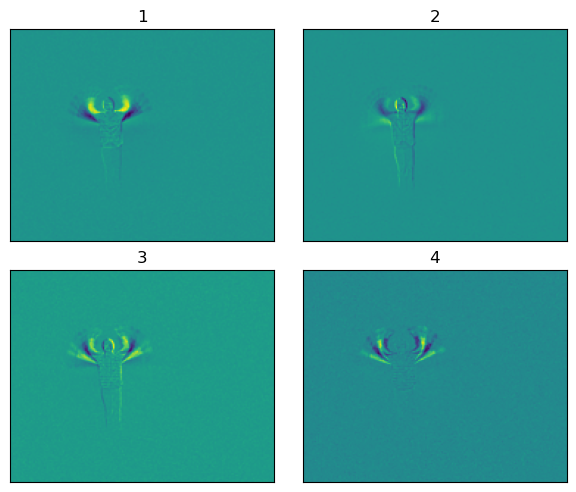

In [4]:
for idx in [0, -1]:
  print(le.classes_[labels[idx]])
  fig, ax = plt.subplots(2, 2, figsize=(6, 5))

  for ii in range(4):
    ax[ii//2, ii%2].imshow(ys[idx][:, ii].reshape((144, 180)))
    ax[ii//2, ii%2].set_title(ii+1)
    ax[ii//2, ii%2].set_xticks([])
    ax[ii//2, ii%2].set_yticks([])

  plt.tight_layout()
  plt.savefig(le.classes_[labels[idx]]+'.pdf', dpi=300)
  plt.show()

# Spectral clustering

In [5]:
from sklearn.metrics.cluster import contingency_matrix, pair_confusion_matrix
from sklearn.cluster import SpectralClustering

def adj_matrix(ys):
  m = len(ys)
  A = np.zeros((m,m))
  if len(ys[0].shape) == 2:
    ord = 'fro'
  elif len(ys[0].shape) == 1:
    ord = 2
  else:
    raise("Data point must be a vector or matrix.")

  for i in range(m):
    for j in range(m):
      A[i, j] = np.linalg.norm(ys[i] - ys[j], ord)
  return A

def get_sigma(A):
  return 10*A[np.triu_indices(len(A), 1)].std()

def run_sc(data):
  A = adj_matrix(data)
  sigma = get_sigma(A)
  print(sigma)
  A = np.exp(-A**2/(2* sigma ** 2))

  sc = SpectralClustering(n_clusters = len(le.classes_), assign_labels='kmeans', affinity='precomputed')
  sc = sc.fit(A)

  plt.imshow(sc.affinity_matrix_)
  plt.colorbar()
  plt.show()

  print(contingency_matrix(labels, sc.labels_))
  print(pair_confusion_matrix(labels, sc.labels_))
  print(labels)
  print(sc.labels_)

  return sc

1.5606349405394015


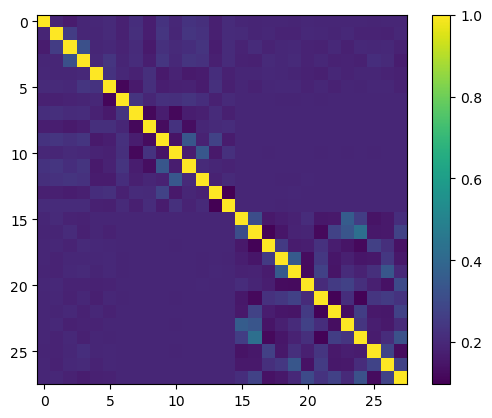

[[15  0]
 [ 6  7]]
[[210 180]
 [ 84 282]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1]


In [6]:
sc = run_sc(ys)

# PSC then Spectral Clustering

In [7]:
from PSC.utils import projection_cost, nuc_cost
from PSC.projections import PCA, manopt_alpha, yhat_alpha_all

from pymanopt.manifolds.stiefel import Stiefel


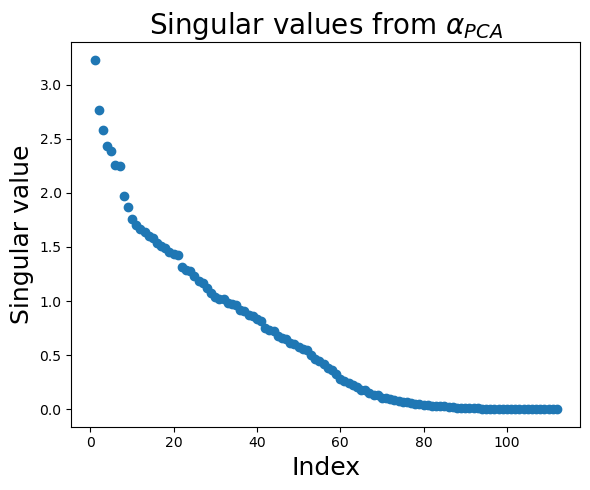

In [8]:
S_hat = np.concatenate(ys, axis=-1) #np.sum(np.array([y.dot(y.T) for y in ys]), axis=0)/m
u, s, _ = np.linalg.svd(S_hat, full_matrices=False)
plt.figure(figsize=(6, 5))
plt.scatter(np.array(range(len(s)))+1, s)
plt.title(r'Singular values from $\alpha_{PCA}$', fontsize=20)
plt.xlabel('Index', fontsize=18)
plt.ylabel('Singular value', fontsize=18)
plt.tight_layout()
plt.savefig('video-singular-values.pdf', dpi=300)

In [9]:
n = 20

alpha_PCA = PCA(ys, n)
alpha_GD = manopt_alpha(ys, alpha_PCA, 1)

X = yhat_alpha_all(alpha_GD, ys)
X = np.array(X).squeeze()

Optimizing...
Terminated - min grad norm reached after 487 iterations, 174.08 seconds.



2.043923411124609


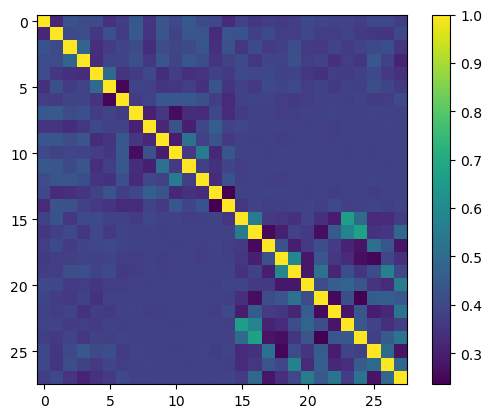

[[15  0]
 [ 6  7]]
[[210 180]
 [ 84 282]]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1]


In [10]:
sc = run_sc(X)

## Map low-dim images back to original pixel space

In [11]:
from PSC.projections import pi_alpha_all

new_y = pi_alpha_all(alpha_GD, ys)

run


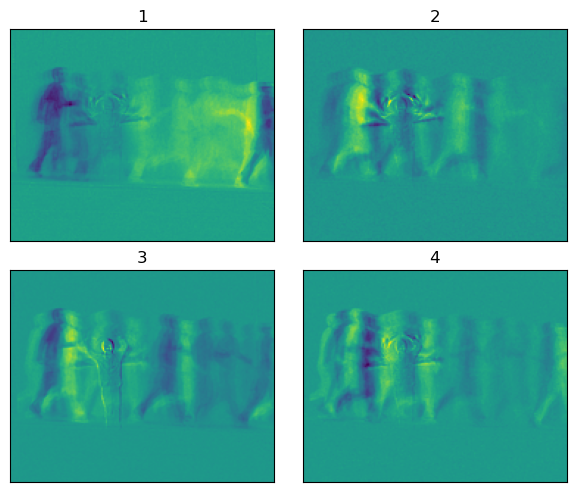

wave2


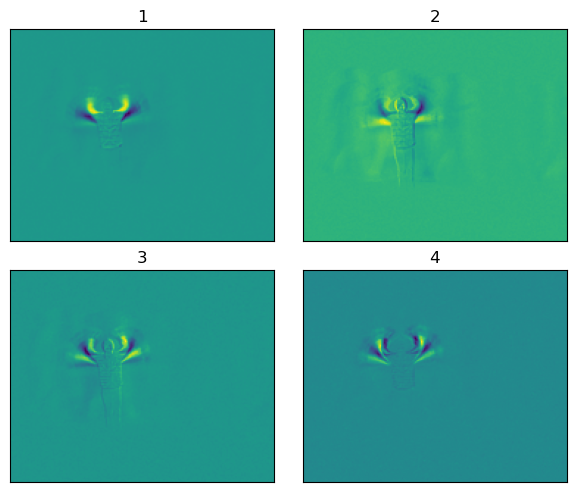

In [12]:
for idx in [0, -1]:
  print(le.classes_[labels[idx]])
  fig, ax = plt.subplots(2, 2, figsize=(6, 5))

  for ii in range(4):
    ax[ii//2, ii%2].imshow(new_y[idx][:, ii].reshape((144, 180)))
    ax[ii//2, ii%2].set_title(ii+1)
    ax[ii//2, ii%2].set_xticks([])
    ax[ii//2, ii%2].set_yticks([])

  plt.tight_layout()
  plt.savefig(le.classes_[labels[idx]]+'_reconstructed.pdf', dpi=300)
  plt.show()

In [ ]:
# ns = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
# mses = []
# for n0 in ns:
#   print(n0)
#   alpha_PCA = PCA(ys, n0)
#   alpha_GD =  manopt_alpha(ys, alpha_PCA, 1)
#   new_y = pi_alpha_all(alpha_GD, ys)

#   mse = ((ys-new_y)**2).sum()/len(ys)
#   print(mse)
#   mses.append(mses)

10
Optimizing...
Terminated - min grad norm reached after 450 iterations, 229.17 seconds.

2.7407684651877795
20
Optimizing...
Terminated - min grad norm reached after 513 iterations, 575.33 seconds.

1.3424732520833622
30
Optimizing...
Terminated - min grad norm reached after 338 iterations, 598.09 seconds.

0.6167759684174304
40
Optimizing...
Terminated - max time reached after 395 iterations.

0.2588682645246391
50
Optimizing...
Terminated - max time reached after 314 iterations.

0.08360550576139444
60
Optimizing...
Terminated - max time reached after 268 iterations.

0.014543036222585359
70
Optimizing...
Terminated - min grad norm reached after 5 iterations, 33.82 seconds.

0.0021038800765287306
80
Optimizing...
Terminated - min grad norm reached after 1 iterations, 34.42 seconds.

0.00023945756105002178
90
Optimizing...
Terminated - min grad norm reached after 1 iterations, 43.61 seconds.

9.422454437091207e-06
100
Optimizing...


/usr/local/lib/python3.10/dist-packages/autograd/numpy/linalg.py:270: RuntimeWarning: divide by zero encountered in divide
  f = 1 / (s[..., anp.newaxis, :]**2 - s[..., :, anp.newaxis]**2 + i)
/usr/local/lib/python3.10/dist-packages/autograd/numpy/linalg.py:278: RuntimeWarning: invalid value encountered in multiply
  t1 = (f * (utgu - anp.conj(T(utgu)))) * s[..., anp.newaxis, :]
/usr/local/lib/python3.10/dist-packages/autograd/numpy/linalg.py:280: RuntimeWarning: invalid value encountered in multiply
  t1 = t1 + s[..., :, anp.newaxis] * (f * (vtgv - anp.conj(T(vtgv))))


LinAlgError in autograd SVD so moving to slower version of manopt_alpha.
Optimizing...
Terminated - min grad norm reached after 1 iterations, 15.71 seconds.

8.135939195409355e-08


In [ ]:
# print(mses)
# [2.7407684651877795, 1.3424732520833622, 0.6167759684174304, 0.2588682645246391, 0.08360550576139444, 0.014543036222585359, 0.0021038800765287306, 0.00023945756105002178, 9.422454437091207e-06, 8.135939195409355e-08]

[2.7407684651877795, 1.3424732520833622, 0.6167759684174304, 0.2588682645246391, 0.08360550576139444, 0.014543036222585359, 0.0021038800765287306, 0.00023945756105002178, 9.422454437091207e-06, 8.135939195409355e-08]


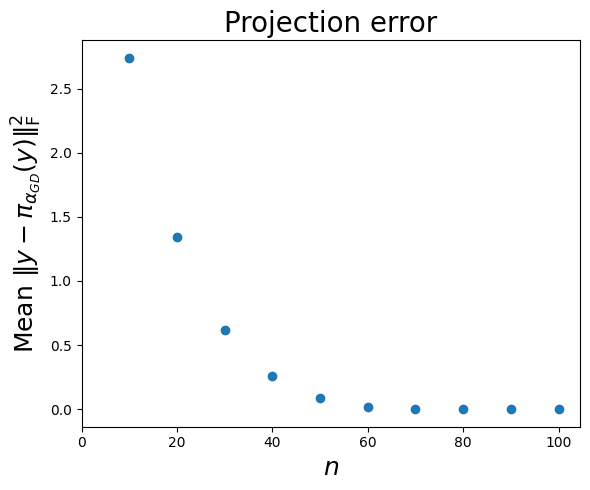

In [ ]:
# plt.figure(figsize=(6, 5))
# plt.scatter(ns, mses)
# plt.title('Projection error', fontsize=20)
# plt.xlabel(r'$n$', fontsize=18)
# plt.ylabel(r'Mean $\|y - \pi_{\alpha_{GD}}(y)\|_\mathrm{F}^2$', fontsize=18)
# plt.xticks([0, 20, 40, 60, 80, 100])
# plt.tight_layout()
# plt.savefig(os.path.join(output_folder, 'video_projection_error.pdf'))